# Cell cycle data preparation

Notebook prepares data for inference tasks.

## Library imports

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc
import scvelo as scv
from anndata import AnnData
from velovi import preprocess_data

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex

from rgv_tools import DATA_DIR, FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## Constants

In [2]:
DATASET = "cell_cycle_rpe1"

In [3]:
SAVE_DATA = True
SAVE_FIGURES = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (FIG_DIR / DATASET / "comparison").mkdir(parents=True, exist_ok=True)

## Function definitions

In [4]:
def prepare_data(adata: AnnData) -> None:
    """Update cell cycle data to include only relevant information in the standard format."""
    adata = adata[adata.obs["labeling_time"] != "dmso", :]
    adata.obs["labeling_time"] = adata.obs["labeling_time"].astype(float)
    adata = adata[adata.obs["experiment"] == "Pulse", :].copy()

    adata.layers["unspliced"] = adata.layers["unlabeled_unspliced"] + adata.layers["labeled_unspliced"]
    adata.layers["spliced"] = adata.layers["unlabeled_spliced"] + adata.layers["labeled_spliced"]

    adata.obs["pseudo_clusters"] = (
        pd.cut(adata.obs["cell_cycle_position"], bins=30, labels=False).astype(str).astype("category")
    )

    adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["cell_cycle_position"], q=30, labels=False)
    adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

    adata.obs["cell_cycle_rad"] = adata.obs["cell_cycle_position"] / adata.obs["cell_cycle_position"].max() * 2 * np.pi

    cell_cycle_phase = pd.read_csv(
        "/lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/cell_cycle_REF/cell_cycle_phase.csv", index_col=0
    )
    adata.obs["cell_cycle_phase"] = cell_cycle_phase.iloc[:, 0]

    adata = adata[:, adata.var["Symbol"].astype(str) != "nan"].copy()
    adata.var.index = adata.var["Symbol"].astype(str)
    del adata.var

    return adata

## Data loading

In [5]:
adata = ad.io.read_h5ad(DATA_DIR / DATASET / "raw" / "gex_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 5422 × 11848
    obs: 'experiment', 'labeling_time', 'plate_id', 'well_id', 'cell_cycle_position', 'RFP_log10_corrected', 'GFP_log10_corrected'
    var: 'Gene_Id', 'Symbol'
    layers: 'labeled_spliced', 'labeled_unspliced', 'new', 'total', 'unlabeled_spliced', 'unlabeled_unspliced'

## Data processing

In [6]:
adata = prepare_data(adata=adata)

if SAVE_DATA:
    adata.write(DATA_DIR / "processed" / "adata.h5ad")

adata

AnnData object with n_obs × n_vars = 2793 × 11195
    obs: 'experiment', 'labeling_time', 'plate_id', 'well_id', 'cell_cycle_position', 'RFP_log10_corrected', 'GFP_log10_corrected', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'cell_cycle_phase'
    layers: 'labeled_spliced', 'labeled_unspliced', 'new', 'total', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

In [7]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=10, layers_normalize=["X", "new", "total", "unspliced", "spliced"], n_top_genes=2000
)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
sc.tl.umap(adata)

adata = preprocess_data(adata)
adata

Filtered out 3163 genes that are detected 10 counts (shared).
Normalized count data: X, new, total, unspliced, spliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
2025-02-16 10:23:26.607144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739697807.435810 1249167 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739697807.847450 1249167 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


AnnData object with n_obs × n_vars = 2793 × 141
    obs: 'experiment', 'labeling_time', 'plate_id', 'well_id', 'cell_cycle_position', 'RFP_log10_corrected', 'GFP_log10_corrected', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'cell_cycle_phase', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'labeled_spliced', 'labeled_unspliced', 'new', 'total', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [8]:
thre_v = [10, 50, 100, 250, 500, 800]
for thre in thre_v:
    true_skeleton = pd.DataFrame(np.zeros((adata.n_vars, adata.n_vars)), index=adata.var_names, columns=adata.var_names)
    for fname in tqdm((DATA_DIR / "raw" / "tf_list_5k").iterdir()):
        regulator = fname.stem
        targets = pd.read_csv(fname, delimiter="\t")["Target_genes"].tolist()

        score = pd.read_csv(fname, delimiter="\t").iloc[:, 1]

        targets = np.array(targets)[score > thre]

        targets = list(adata.var_names.intersection(targets))

        if len(targets) > 3 and regulator in adata.var_names:
            true_skeleton.loc[regulator, targets] = 1

    adata.varm[f"true_skeleton_{thre}"] = csr_matrix(true_skeleton.values)

15it [00:01, 12.63it/s]
15it [00:00, 51.41it/s]
15it [00:00, 52.30it/s]
15it [00:00, 53.67it/s]
15it [00:00, 54.37it/s]
15it [00:00, 54.78it/s]


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


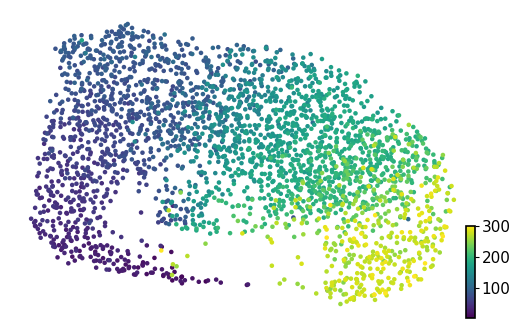

In [11]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="cell_cycle_position", cmap="viridis", title="", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / DATASET / "comparison" / "sceu_cell_cycle_umap.svg",
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

## Calculating cell cycling phase

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


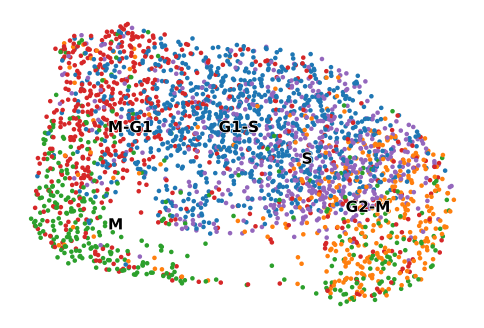

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="cell_cycle_phase", cmap="viridis", title="", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / DATASET / "comparison" / "sceu_cell_cycle_phase_umap.svg",
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

In [13]:
if SAVE_DATA:
    adata.write(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad")